In [50]:
import quandl
import pandas as pd
import numpy as np
import talib
import csv
import warnings
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from functools import total_ordering
from trading import generate_signals, eval_signals,time_series_chart
from commodities import hard_tech,hard,hard_pct
from spy import spy,spy_pct,benchmark_start

In [4]:
from testing import test_model_mapping,series_merge

In [55]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [39]:
spy_pct.name='pct_spy'
assets=hard_pct.join(spy_pct).dropna()

In [41]:
def test_model_mapping(df,assets, model=GaussianHMM,n_components=3,train_size=5000,begin_date='2015-01-01'):
    #makes a Markov model using the df, and finds the optimal mapping from states to trade signals
    train=df.iloc[:train_size]
    hmm=model(n_components=3, covariance_type="full", n_iter=1000).fit(train)
    models=[]
    for mapping in [[x,y,z] for x in [-1,0,1] for y in [-1,0,1] for z in [-1,0,1]]:
        def strat(row,hmm=hmm,mapping=mapping):
            ret=hmm.predict([row])[0]
            return mapping[ret]
        trade=generate_signals(df.loc[begin_date:],strat)
        for asset in assets.columns:
            prices,sigs=series_merge(assets[asset][begin_date:],trade)
            perf=eval_signals(prices,sigs)
            models.append(MarkovStrategy(strat,perf,asset))
    return sorted(models,reverse=True)

In [42]:
ranking=test_model_mapping(hard_tech,assets,train_size=5000)

In [46]:
ben=benchmark_start('2015-01-01')

In [47]:
ben=pd.Series(ben,index=pd.to_datetime(ben.index))

In [48]:
top_ranked=ranking[0].returns['2015-01-01':]
ben,top_ranked=series_merge(ben,top_ranked)

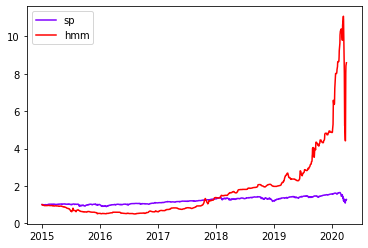

In [54]:
time_series_chart(sp=ben,hmm=top_ranked)